# Code
***

# 1pm 07/05 - Different attempt

# Load

In [10]:
# Imports
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import numpy as np
import time
from tensorflow.keras import mixed_precision

# Enable Mixed Precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Load Dataset
student_id_seed = 432121 # Seed for reproducibility

dataset_dir = 'E:\\GUI\\hagridset'  # Path to your dataset directory
image_size = (64, 64)
batch_size = 16
validation_split = 0.2

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="training",
    seed=student_id_seed,
    image_size=image_size,
    batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="validation",
    seed=student_id_seed,
    image_size=image_size,
    batch_size=batch_size
)

# Save the class names
class_names = train_ds.class_names
num_classes = len(class_names)

# Further split validation set into val and test
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2 * val_batches) // 3)
val_ds = val_ds.skip((2 * val_batches) // 3)

# Cache and prefetch data for performance improvement
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 125912 files belonging to 18 classes.
Using 100730 files for training.
Found 125912 files belonging to 18 classes.
Using 25182 files for validation.


# Define and train cnn 

Epoch 1/10
6296/6296 [==============================] - 231s 32ms/step - loss: 2.2250 - accuracy: 0.2807 - val_loss: 1.4487 - val_accuracy: 0.5449
Epoch 2/10
6296/6296 [==============================] - 57s 9ms/step - loss: 1.4502 - accuracy: 0.5265 - val_loss: 1.0815 - val_accuracy: 0.6440
Epoch 3/10
6296/6296 [==============================] - 57s 9ms/step - loss: 1.1873 - accuracy: 0.6121 - val_loss: 0.9213 - val_accuracy: 0.7129
Epoch 4/10
6296/6296 [==============================] - 57s 9ms/step - loss: 1.0517 - accuracy: 0.6585 - val_loss: 0.8881 - val_accuracy: 0.7122
Epoch 5/10
6296/6296 [==============================] - 58s 9ms/step - loss: 0.9592 - accuracy: 0.6898 - val_loss: 0.8655 - val_accuracy: 0.7236
Epoch 6/10
6296/6296 [==============================] - 57s 9ms/step - loss: 0.8997 - accuracy: 0.7074 - val_loss: 0.7512 - val_accuracy: 0.7572
Epoch 7/10
6296/6296 [==============================] - 57s 9ms/step - loss: 0.8527 - accuracy: 0.7218 - val_loss: 0.7332 - val_

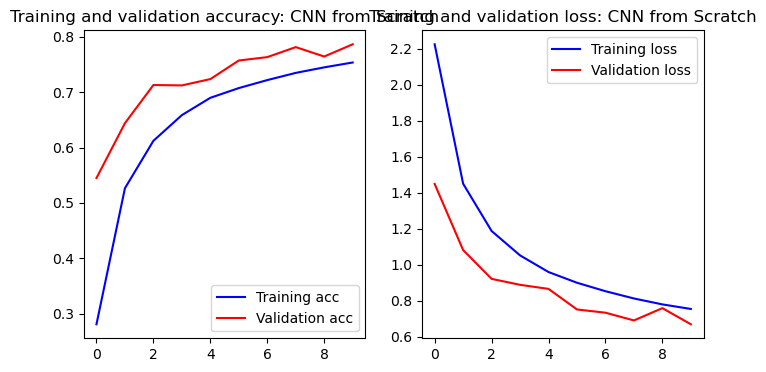

In [11]:
# Function to build a simple CNN model
def build_scratch_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Rescaling(1./255, input_shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')  # Explicitly set dtype
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Train and evaluate the scratch model
input_shape = (64, 64, 3)

model_scratch = build_scratch_model(input_shape, num_classes)
history_scratch = model_scratch.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    batch_size=batch_size
)

# Evaluate on test set
test_loss, test_acc = model_scratch.evaluate(test_ds)
print(f"Scratch Model Test Accuracy: {test_acc:.2f}")

# Function to visualize training history
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title(f'Training and validation accuracy: {title}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'Training and validation loss: {title}')
    plt.legend()

    plt.show()

# Plot history
plot_history(history_scratch, "CNN from Scratch")

# Transfer learning

Epoch 1/20
6296/6296 [==============================] - 83s 13ms/step - loss: 2.5793 - accuracy: 0.1704 - val_loss: 2.0147 - val_accuracy: 0.3314
Epoch 2/20
6296/6296 [==============================] - 80s 13ms/step - loss: 1.4117 - accuracy: 0.5201 - val_loss: 0.9950 - val_accuracy: 0.6712
Epoch 3/20
6296/6296 [==============================] - 86s 14ms/step - loss: 0.8941 - accuracy: 0.7070 - val_loss: 0.8766 - val_accuracy: 0.7102
Epoch 4/20
6296/6296 [==============================] - 88s 14ms/step - loss: 0.7212 - accuracy: 0.7639 - val_loss: 0.8450 - val_accuracy: 0.7312
Epoch 5/20
6296/6296 [==============================] - 89s 14ms/step - loss: 0.6077 - accuracy: 0.7999 - val_loss: 0.8663 - val_accuracy: 0.7409
Epoch 6/20
6296/6296 [==============================] - 83s 13ms/step - loss: 0.5200 - accuracy: 0.8283 - val_loss: 0.9471 - val_accuracy: 0.7280
Epoch 7/20
6296/6296 [==============================] - 82s 13ms/step - loss: 0.4493 - accuracy: 0.8513 - val_loss: 0.9154 -

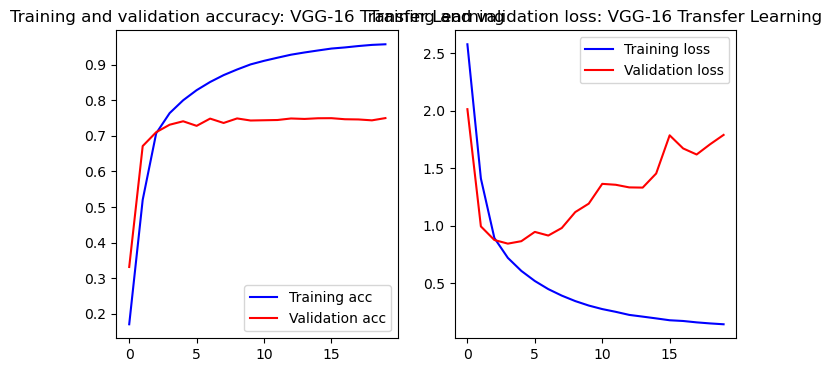

In [12]:
# Load VGG-16 Model with Transfer Learning and Fine-tuning
def build_transfer_model(input_shape, num_classes):
    base_model = VGG16(
        weights='imagenet',
        input_shape=input_shape,
        include_top=False
    )

    # Unfreeze the last 4 layers for fine-tuning
    for layer in base_model.layers[:-4]:
        layer.trainable = False
    for layer in base_model.layers[-4:]:
        layer.trainable = True

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')  # Explicitly set dtype
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Train and evaluate the transfer model
input_shape = (64, 64, 3)
model_transfer = build_transfer_model(input_shape, num_classes)

history_transfer = model_transfer.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    batch_size=batch_size
)

# Evaluate on test set
test_loss, test_acc = model_transfer.evaluate(test_ds)
print(f"Transfer Learning Model Test Accuracy: {test_acc:.2f}")

# Function to visualize training history
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title(f'Training and validation accuracy: {title}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'Training and validation loss: {title}')
    plt.legend()

    plt.show()

plot_history(history_transfer, "VGG-16 Transfer Learning")

# Comparison and Testing

In [8]:
# Compare inference times
import time

def measure_inference_time(model, dataset):
    start_time = time.time()
    model.evaluate(dataset)
    elapsed_time = time.time() - start_time
    return elapsed_time

inference_time_scratch = measure_inference_time(model_scratch, test_ds)
inference_time_transfer = measure_inference_time(model_transfer, test_ds)

print(f"Inference Time - Scratch Model: {inference_time_scratch:.2f}s")
print(f"Inference Time - Transfer Model: {inference_time_transfer:.2f}s")


   1/1049 [..............................] - ETA: 13s - loss: 2.9060 - accuracy: 0.0000e+00

1049/1049 [==============================] - 8s 7ms/step - loss: 2.8902 - accuracy: 0.0618
Inference Time - Scratch Model: 5.04s
Inference Time - Transfer Model: 7.61s


In [18]:
# Final test using self-taken images
from tensorflow.keras.preprocessing import image

def predict_gesture(model, img_path, class_names):
    img = image.load_img(img_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch dimension

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]
    return predicted_class

# Assuming you have your images in '/content/my_gestures'
gesture_images = ['images/image_like.jpg',
                  'images/image_ok.jpg',
                  'images/image_stop.jpg',
                  'images/image_two.jpg']

for img_path in gesture_images:
    predicted_gesture = predict_gesture(model_scratch, img_path, class_names)
    print(f"Prediction for {img_path}: {predicted_gesture}")


1/1 [==============================] - 0s 22ms/step
Prediction for images/image_like.jpg: like
1/1 [==============================] - 0s 23ms/step
Prediction for images/image_ok.jpg: ok
1/1 [==============================] - 0s 23ms/step
Prediction for images/image_stop.jpg: stop
1/1 [==============================] - 0s 25ms/step
Prediction for images/image_two.jpg: two_up
